#### Atmospheric Neutrinos Uncertainties assumed in the Boosted Dark Matter Analysis.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import math
import ROOT 

Let's load Atmospheric Neutrino Samples:

In [2]:
LIST_NUCLEARMODELS = ['hA_BR','hA_LFG', 'hA_ESF', 'hN_BR', 'hN_LFG', 'hN_ESF']

def ReadNuclearModelSamples():

        fAtm_00a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00a_newVertex/atm_hA_BR.root')
        fAtm_01a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01a_newVertex/atm_hA_LFG.root')
        fAtm_02a = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02a_newVertex/atm_hA_ESF.root')
        fAtm_00b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/00b_newVertex/atm_hN_BR.root')
        fAtm_01b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/01b_newVertex/atm_hN_LFG.root')
        fAtm_02b = ROOT.TFile.Open('/home/leoperes/ntuples_grid_newVertex/02b_newVertex/atm_hN_ESF.root')
        samples = [fAtm_00a, fAtm_01a, fAtm_02a, fAtm_00b, fAtm_01b, fAtm_02b]
        return samples

def GetNpArraysFromTrees2(tree, branch_name):
    estimate = 3e8 #amount of numbers getting from branch
    tree.SetEstimate(int(estimate))
    result_hist = tree.Draw(branch_name, "", "goff")
    result = np.asarray(np.frombuffer(tree.GetV1(), count=result_hist))
    result = result.copy()
    return result

infiles_list = ReadNuclearModelSamples()
intrees_reco = [lambda arg=infile: arg.Get("ana/Atm") for infile in infiles_list]
reco_entries = [lambda arg=intree: arg.Get("ana/Atm").GetEntries() for intree in infiles_list]

##### Sources of systematic uncertainties:
> - Overall Neutrino Flux Uncertainty
> - Geometrical Effect makes Atmospheric Neutrino Flux not exactly isotropic.
> - Signal contamination in the side band region.

First topic is the calculation of the Overall neutrino flux uncertainty. Using the sideband from the angular cuts to constraint background uncertainty.
Thus, we take every angular distribution from the 6 nuclear models. Apply the angular selection cuts for each BDM sample, and then, take the percentage refer to the square root of the number expected events in the sideband  ($\sqrt{N_{bkg}}$).




#### Let's plot the angular distribution of atmospheric neutrinos w.r.t Sun's direction for each nuclear model.

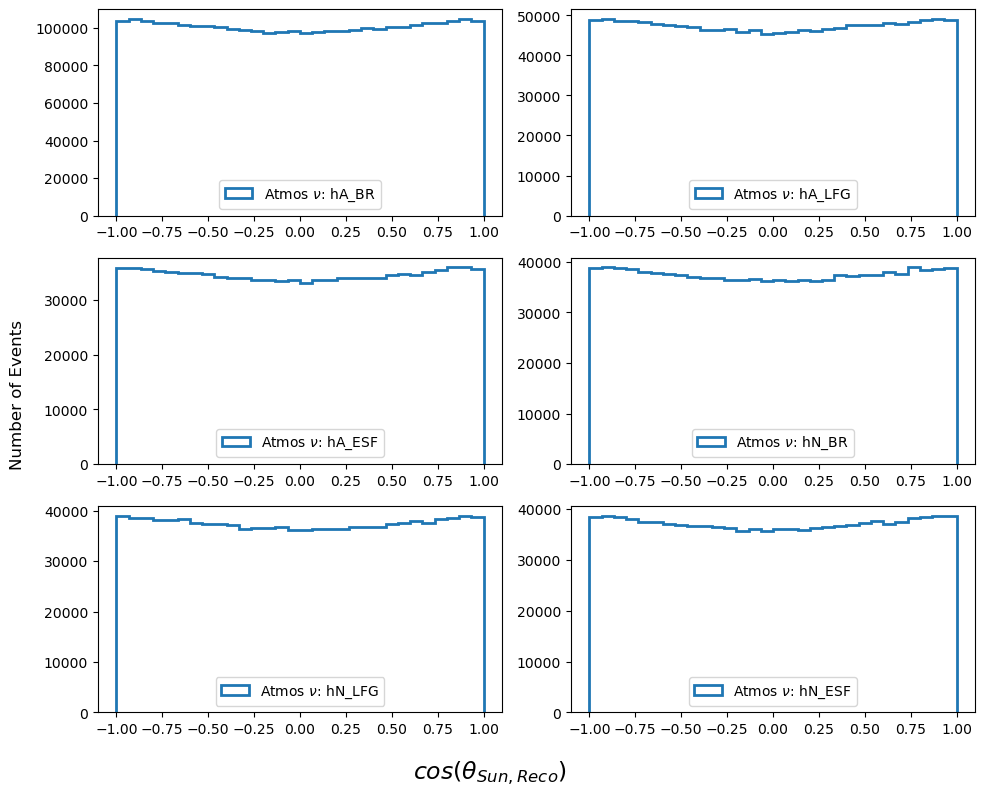

In [3]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

hist_numodel = []
for SAMPLE_INDEX in range(0,6):
    ### Atmospheric neutrinos Angular Reconstruction w.r.t Sun

    TotalMomRecoRangeUnitVect_Reco = GetNpArraysFromTrees2(intrees_reco[SAMPLE_INDEX]()," TotalMomRecoRangeUnitVect")
    nSimulatedEvtsReco_atm = reco_entries[SAMPLE_INDEX]()
    Reco_mom_Nu = np.reshape(TotalMomRecoRangeUnitVect_Reco, (nSimulatedEvtsReco_atm,3))
    Sun_Positions = np.loadtxt('../FinalPlots/background_sun_pos.dat', delimiter='\t', usecols=(0,1,2))

    hist_cos_reco = []
    for index, atmevt in enumerate(Reco_mom_Nu):
        indices = np.random.randint(0, len(Sun_Positions), size=1)
        # Use the sampled indices to select elements from the array
        sample_sunpos = Sun_Positions[indices]
        for sunpos in sample_sunpos:
            hist_cos_reco.append(np.sum(atmevt*sunpos))

    hist_numodel.append(hist_cos_reco)

# Plot each graph
for i, ax in enumerate(axes):
    ax.hist(hist_numodel[i], bins = 30,histtype = 'step', label=r'Atmos $\nu$: '+LIST_NUCLEARMODELS[i], lw =2)
    ax.legend(loc = 'lower center')

# Add a single unique x label at the bottom
fig.supxlabel(r'$cos(\theta_{Sun, Reco})$',fontsize = 17)

# Add a single unique y label on the left
fig.supylabel('Number of Events')

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('AtmosphericsNuDistributionWRTSunSeparated.pdf', format='pdf', dpi=600)
# Show the plots
plt.show()

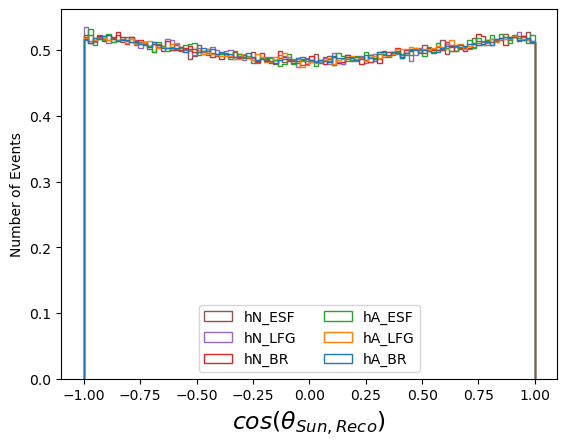

In [4]:
plt.figure(dpi=100)
plt.hist([f for f in hist_numodel], bins = 100, histtype = 'step', label= [l for l in LIST_NUCLEARMODELS], density=1)
#plt.title(f'index number evt: {index}')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun, Reco})$',fontsize = 17)
plt.legend(loc = 'lower center', ncols =2)
plt.savefig('AtmosphericsNuDistributionWRTSun.pdf', format='pdf', dpi=600)
plt.show()

#### Estimating the uncertainty from the sideband:

In [5]:
main_folder = '../FinalPlots/OptimalCuts/NuclearModelsOptSelectionApplication_MaxCVN/'
#Atmospheric Neutrino Angular Distributions 
CosSun_Atm_list = ['hA_BR/CosSun_Atm_00a.txt','hA_LFG/CosSun_Atm_01a.txt', 'hA_ESF/CosSun_Atm_02a.txt', 'hN_BR/CosSun_Atm_00b.txt','hN_LFG/CosSun_Atm_01b.txt', 'hN_ESF/CosSun_Atm_02b.txt']
OptimalAngCuts = np.loadtxt('Eff_Bkg_index_00a.txt', usecols=(1,2,4), skiprows=1)
#Sample labels
labelsamples= ["b1p1_m05","b1p1_m10","b1p1_m20","b1p1_m40","b1p5_m05","b1p5_m10","b1p5_m20","b1p5_m40","b10_m05","b10_m10","b10_m20","b10_m40"]
ExpectedNumber10kty = [4*10*2495.98, 4*10*2586.47, 4*10*2401.88]
print('========== SYSTEMATIC UNCERTAINTY PER NUCLEAR MODEL BY THE SIDE BAND CONSTRAINT ===========')
ExpectedBkgList = ExpectedNumber10kty

LargerUnc = 1e-3

for index in range(0, len(labelsamples)):
    for i in range(0,len(CosSun_Atm_list)):
        
        ExpectedBkg = 0
        if i % 3 == 0:
            ExpectedBkg = ExpectedBkgList[0]
        if i % 3 == 1:
            ExpectedBkg = ExpectedBkgList[1]
        if i % 3 == 2:
            ExpectedBkg = ExpectedBkgList[2]

        print('====================================================\n')
        print('Atmospheric Nuclear Model: '+ CosSun_Atm_list[i])
        AtmosphericSample = np.loadtxt(main_folder+CosSun_Atm_list[i])
        print('Sample: '+labelsamples[index]+'\n')
        print(f'Total Expected Number of Neutrinos Interactions: {round(ExpectedBkg)}\n')
        print(f'Number of Atmospheric Neutrinos Events Reconstructed: {AtmosphericSample.size}')
        print(f'Optimal Cosine Cuts => cos(theta_Sun) < {OptimalAngCuts[index][0]} and cos(theta_Sun) > {OptimalAngCuts[index][1]}. \n')
        EventsWithinOptAngCuts = AtmosphericSample[AtmosphericSample < OptimalAngCuts[index][0]].size +  AtmosphericSample[AtmosphericSample > OptimalAngCuts[index][1]].size
        print(f'Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: {EventsWithinOptAngCuts} \n')
        ExpectedBkgWithinOptAngCuts = ExpectedBkg*(EventsWithinOptAngCuts/AtmosphericSample.size)
        print(f'Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: {round(ExpectedBkgWithinOptAngCuts)} \n')
        print(f'Square root: {round(math.sqrt(ExpectedBkgWithinOptAngCuts))}')
        print(f'Uncertainty: {round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100 }%')

        if (round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100 >  LargerUnc):
            LargerUnc = round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100
print(f'The Larger uncertainty found combining all nuclear models in all selection cuts is: {LargerUnc} %')


========== SYSTEMATIC UNCERTAINTY PER NUCLEAR MODEL BY THE SIDE BAND CONSTRAINT ===========

Atmospheric Nuclear Model: hA_BR/CosSun_Atm_00a.txt
Sample: b1p1_m05

Total Expected Number of Neutrinos Interactions: 99839

Number of Atmospheric Neutrinos Events Reconstructed: 220573
Optimal Cosine Cuts => cos(theta_Sun) < -0.9 and cos(theta_Sun) > 0.9. 

Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 22677 

Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 10264 

Square root: 101
Uncertainty: 1.0%

Atmospheric Nuclear Model: hA_LFG/CosSun_Atm_01a.txt
Sample: b1p1_m05

Total Expected Number of Neutrinos Interactions: 103459

Number of Atmospheric Neutrinos Events Reconstructed: 1420286
Optimal Cosine Cuts => cos(theta_Sun) < -0.9 and cos(theta_Sun) > 0.9. 

Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 147182 

Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cut

## The Larger uncertainty found combining all nuclear models in all selection cuts is: 1.5 %.

### Step 2: Estimate the uncertainty given by the almost isotropic angular distribution of atmospheric neutrinos w.r.t Sun's direction.

In [6]:
for numodel in hist_numodel:
    hist, bin_edges = np.histogram(numodel, bins = 20)
    print(np.max(hist)/np.min(hist))

1.0699347659247889
1.0725693225693225
1.0779108902956969
1.0742728563787602
1.0762588335147703
1.0825123843349846


Current angular resolution is set $\approx 40$ degrees. 20 bins means a 0.1 step.
##  Thus, we take as a conservative uncertainty for the quasi-uniform distribution as: 8 %. 

### Step 3: Uncertainty from BDM signal reconstruction in the sideband.
We need to estimate conservatively the number of signal events in the sideband region. There is no way to know the exactly central value expected for signal events because we would need to estimate the upper limit for the coupling constant $g_{Z'}$.

In [7]:
list_info = ['Eff_Bkg_index_00a.txt', 'Eff_Bkg_index_01a.txt', 'Eff_Bkg_index_02a.txt', 'Eff_Bkg_index_00b.txt', 'Eff_Bkg_index_01b.txt', 'Eff_Bkg_index_02b.txt']

EffSig_nBkg = [lambda arg=info:  np.loadtxt(info, usecols=(3,4), skiprows=1) for info in list_info]

for index in range(0, len(labelsamples)):
    for i in range(0,len(CosSun_Atm_list)):
        
        ExpectedBkg = 0
        if i % 3 == 0:
            ExpectedBkg = ExpectedBkgList[0]
        if i % 3 == 1:
            ExpectedBkg = ExpectedBkgList[1]
        if i % 3 == 2:
            ExpectedBkg = ExpectedBkgList[2]

        print('====================================================\n')
        print('Atmospheric Nuclear Model: '+ CosSun_Atm_list[i])
        AtmosphericSample = np.loadtxt(main_folder+CosSun_Atm_list[i])
        print('Sample: '+labelsamples[index]+'\n')
        print(f'Total Expected Number of Neutrinos Interactions: {round(ExpectedBkg)}\n')
        print(f'Number of Atmospheric Neutrinos Events Reconstructed: {AtmosphericSample.size}')
        print(f'Optimal Cosine Cuts => cos(theta_Sun) < {OptimalAngCuts[index][0]} and cos(theta_Sun) > {OptimalAngCuts[index][1]}. \n')
        EventsWithinOptAngCuts = AtmosphericSample[AtmosphericSample < OptimalAngCuts[index][0]].size +  AtmosphericSample[AtmosphericSample > OptimalAngCuts[index][1]].size
        print(f'Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: {EventsWithinOptAngCuts} \n')
        ExpectedBkgWithinOptAngCuts = ExpectedBkg*(EventsWithinOptAngCuts/AtmosphericSample.size)
        print(f'Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: {round(ExpectedBkgWithinOptAngCuts)} \n')
        print(f'Square root: {round(math.sqrt(ExpectedBkgWithinOptAngCuts))}')
        print(f'Uncertainty: {round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100 }%')

        if (round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100 >  LargerUnc):
            LargerUnc = round(math.sqrt(ExpectedBkgWithinOptAngCuts)/ExpectedBkgWithinOptAngCuts,3)*100
print(f'The Larger uncertainty found combining all nuclear models in all selection cuts is: {LargerUnc} %')



Atmospheric Nuclear Model: hA_BR/CosSun_Atm_00a.txt
Sample: b1p1_m05

Total Expected Number of Neutrinos Interactions: 99839

Number of Atmospheric Neutrinos Events Reconstructed: 220573
Optimal Cosine Cuts => cos(theta_Sun) < -0.9 and cos(theta_Sun) > 0.9. 

Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 22677 

Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 10264 

Square root: 101
Uncertainty: 1.0%

Atmospheric Nuclear Model: hA_LFG/CosSun_Atm_01a.txt
Sample: b1p1_m05

Total Expected Number of Neutrinos Interactions: 103459

Number of Atmospheric Neutrinos Events Reconstructed: 1420286
Optimal Cosine Cuts => cos(theta_Sun) < -0.9 and cos(theta_Sun) > 0.9. 

Number of Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 147182 

Number of Expected Atmospheric Neutrino Events Reconstructed inside the Angular Cuts: 10721 

Square root: 104
Uncertainty: 1.0%

Atmospheric Nuclear Model: hA_ESF/CosSun_Atm_

### Let's fit the angular Neutrino distribution w.r.t Sun.

In [53]:
def fit_atmospherics(model):    
    # Create a histogram
    counts, bin_edges = np.histogram(model, bins=10, density=True)
    # Get the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Fit a polynomial to the histogram data (e.g., a 3rd-degree polynomial)
    coefficients, cov = np.polyfit(bin_centers, counts, deg=2, cov= True)
    
    return coefficients, cov



In [54]:
results = []
for model in hist_numodel:
    results.append(fit_atmospherics(model))

In [55]:
results[0][0]

array([ 0.03768895, -0.00050179,  0.48756286])

In [56]:
np.sqrt(np.diag(results[0][1]))

array([0.00223882, 0.00113276, 0.00098452])

Area under the curve: 1.0002516871643448


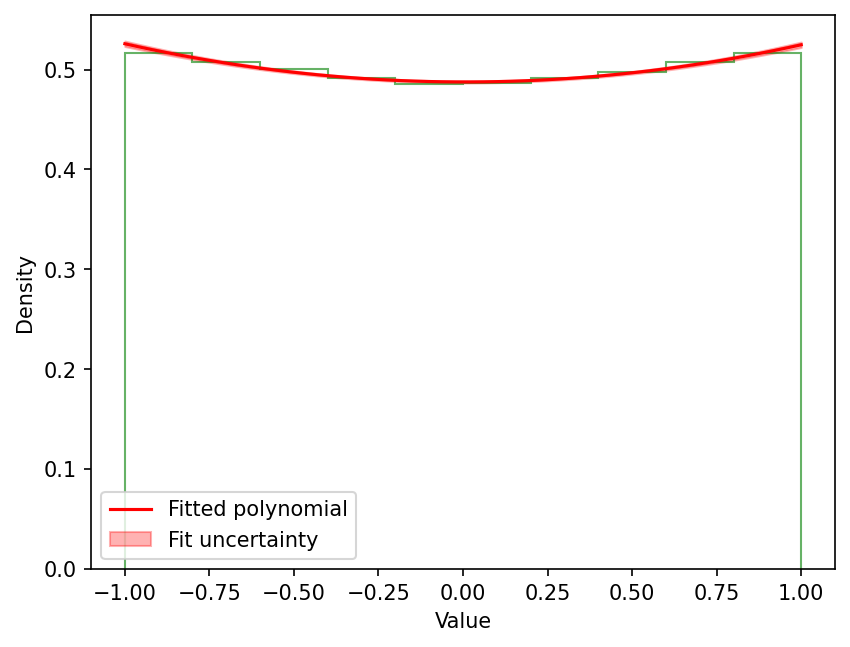

In [58]:
from scipy.integrate import quad
# Create a polynomial function using the coefficients
polynomial = np.poly1d(results[0][0])
# Generate points to plot the polynomial
x_values = np.linspace(-1, 1, 50)
y_values = polynomial(x_values)


uncertainties = np.sqrt(np.diag(results[0][1]))

# Propagate the uncertainty to the fit
y_fit_uncertainty = np.sqrt(
    (uncertainties[0] * x_values**2)**2 +
    (uncertainties[1] * x_values)**2 +
    (uncertainties[2])**2
)

# Integrate the polynomial function over the range of x
area_under_curve, _ = quad(polynomial, -1, 1)
print(f"Area under the curve: {area_under_curve}")

plt.figure(dpi=150)

# Plot data points
plt.hist(hist_numodel[0], bins=10, density=True, alpha=0.6, color='g', histtype='step')

# Plot the fitted polynomial
plt.plot(x_values, y_values, label='Fitted polynomial', color='red')

# Plot the fit uncertainty as a shaded region
plt.fill_between(x_values, y_values - y_fit_uncertainty, y_values + y_fit_uncertainty, 
                 color='red', alpha=0.3, label='Fit uncertainty')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

Area under the curve: 1.0002516871643448


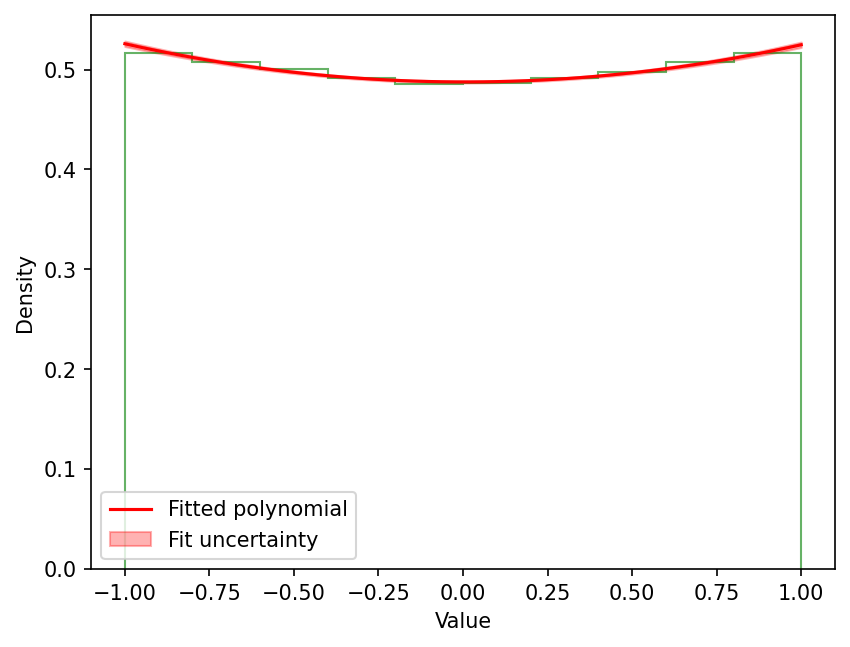

Area under the curve: 1.0002563641305562


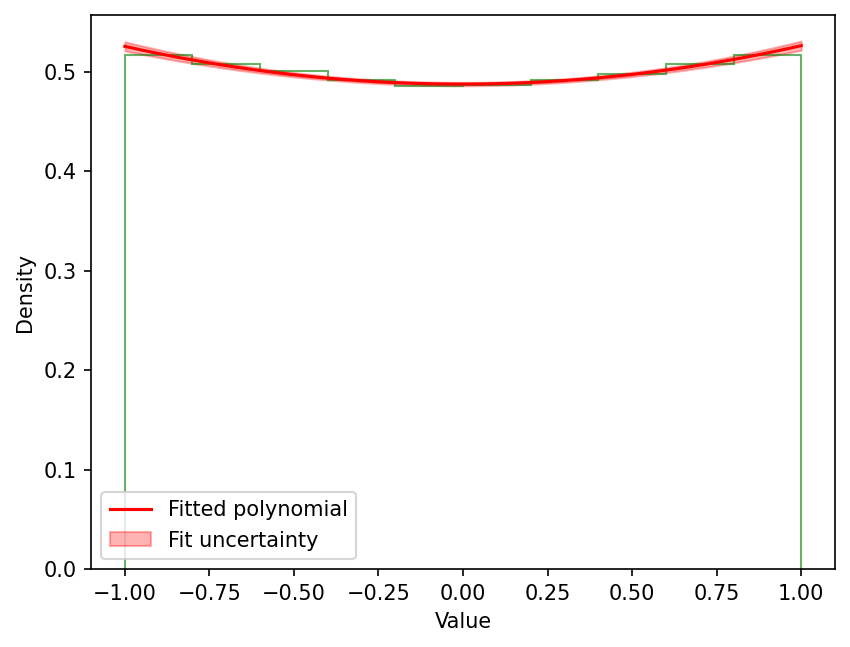

Area under the curve: 1.0002673599479635


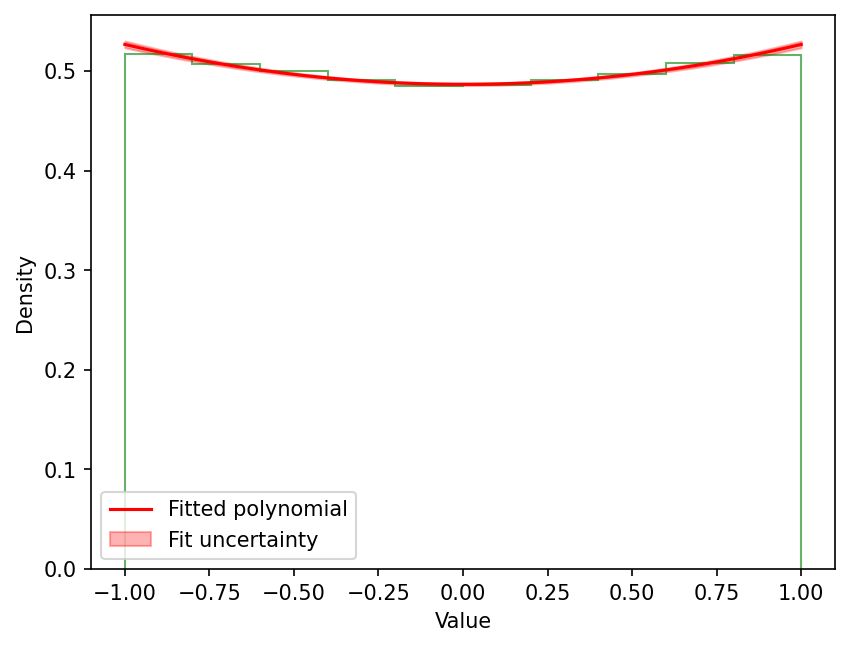

Area under the curve: 1.0002689255353963


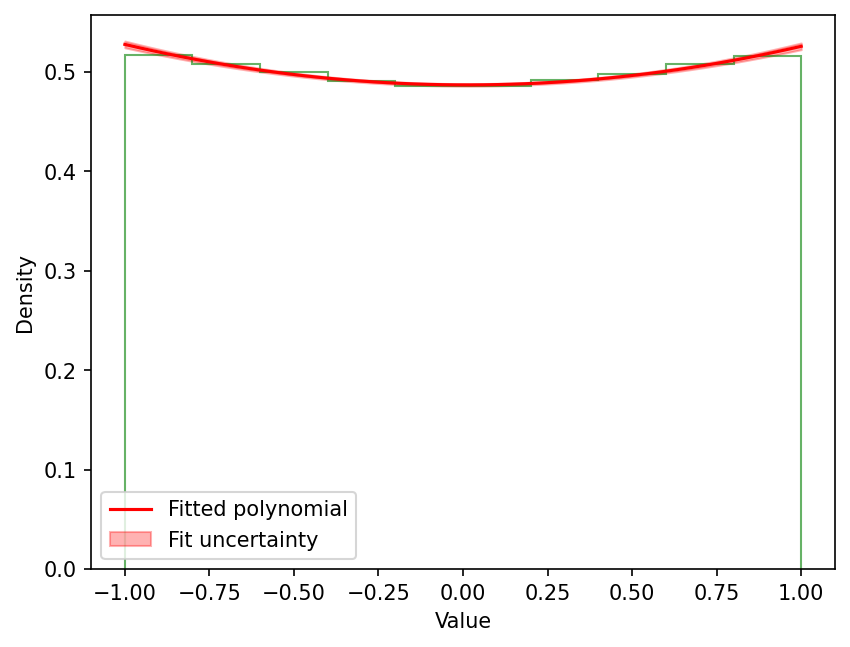

Area under the curve: 1.000266535970406


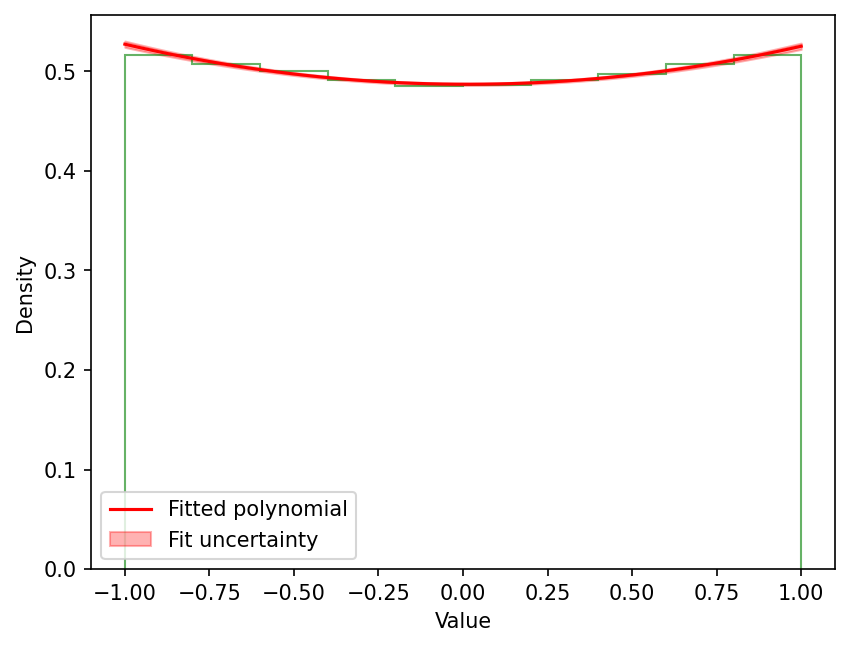

Area under the curve: 1.0002805716786551


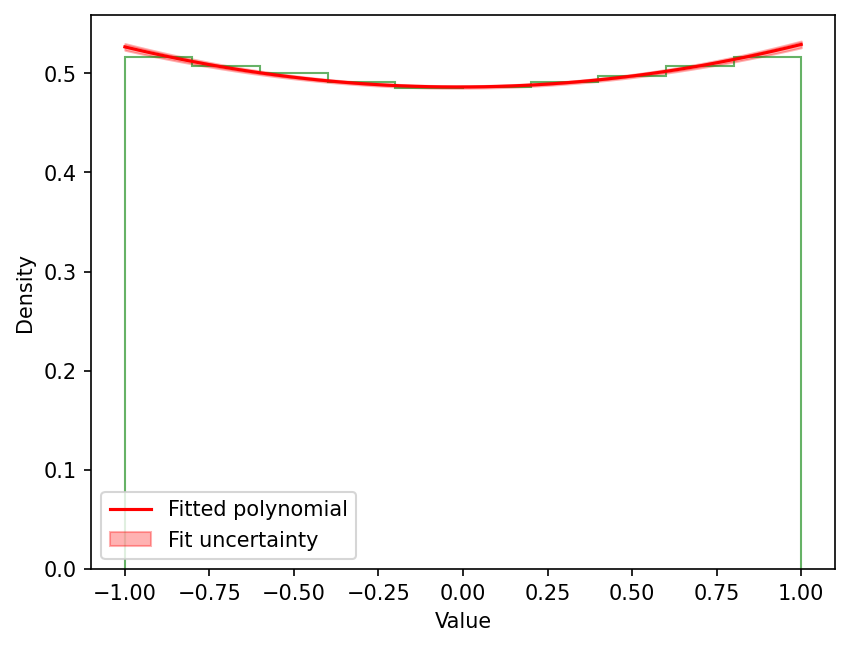

In [59]:
for id,model in enumerate(hist_numodel):
    
    # Create a polynomial function using the coefficients
    polynomial = np.poly1d(results[id][0])
    # Generate points to plot the polynomial
    x_values = np.linspace(-1, 1, 50)
    y_values = polynomial(x_values)


    uncertainties = np.sqrt(np.diag(results[id][1]))

    # Propagate the uncertainty to the fit
    y_fit_uncertainty = np.sqrt(
        (uncertainties[0] * x_values**2)**2 +
        (uncertainties[1] * x_values)**2 +
        (uncertainties[2])**2
    )

    # Integrate the polynomial function over the range of x
    area_under_curve, _ = quad(polynomial, -1, 1)
    print(f"Area under the curve: {area_under_curve}")

    plt.figure(dpi=150)

    # Plot data points
    plt.hist(hist_numodel[0], bins=10, density=True, alpha=0.6, color='g', histtype='step')

    # Plot the fitted polynomial
    plt.plot(x_values, y_values, label='Fitted polynomial', color='red')

    # Plot the fit uncertainty as a shaded region
    plt.fill_between(x_values, y_values - y_fit_uncertainty, y_values + y_fit_uncertainty, 
                     color='red', alpha=0.3, label='Fit uncertainty')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()